In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [2]:
df = pd.read_csv('creditcard.csv')

print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


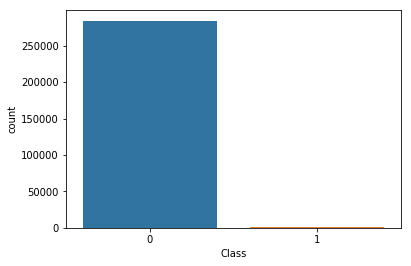

In [3]:
print(df.Class.value_counts())

sns.countplot(df.Class)

From the plot above, we can see we have a very imbalanced class.  

By working through the tutorial found here:  https://elitedatascience.com/imbalanced-classes we can effective ways to deal with class imbalance.

In [4]:
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# first setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [5]:
# Modeling the data as is
# Train model
take_0 = LogisticRegression().fit(X_train, y_train)
 
# Predict on training set
take_0_y_ = take_0.predict(X_test)

In [6]:
# Checking accuracy
accuracy_score(y_test, take_0_y_)

0.9992135052386169

In [7]:
# Checking unique values
predictions = pd.DataFrame(take_0_y_)
predictions[0].value_counts()

0    71108
1       94
Name: 0, dtype: int64

We have a very high accuracy score of 0.999 but that is only because the model is predicting mostly no fraud cases.  We can attempt to deal with this in several different ways.

## 1. Up-sample Minority Class

In [8]:
from sklearn.utils import resample

In [9]:
# separate minority and majority classes
not_fraud = df[df.Class==0]
fraud = df[df.Class==1]

# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=284315, # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled.Class.value_counts()

1    284315
0    284315
Name: Class, dtype: int64

In [10]:
# trying logistic regression again with the balanced dataset

y = upsampled.Class
X = upsampled.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

take_1 = LogisticRegression().fit(X_train, y_train)

take_1_y_ = take_1.predict(X_test)

In [11]:
# Checking accuracy
accuracy_score(y_test, take_1_y_)

0.9379563584180982

In [12]:
# Checking unique values
predictions['Prediction'] = pd.DataFrame(take_1_y_)
predictions.Prediction.value_counts()

0    38060
1    33142
Name: Prediction, dtype: int64

Our accuracy score decreased after upsampling, but the model is now predicting both classes more equally, making it a better model.

## 2. Down-sample Majority Class

In [13]:
# still using our separated classes fraud and not_fraud from above

# downsample majority
not_fraud_downsampled = resample(not_fraud,
                                replace = False, # sample without replacement
                                n_samples = 492, # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_fraud_downsampled, fraud])

# checking counts
downsampled.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

In [14]:
# trying logistic regression again with the balanced dataset

y = downsampled.Class
X = downsampled.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

take_2 = LogisticRegression().fit(X_train, y_train)

take_2_y_ = take_2.predict(X_test)

In [15]:
# Checking accuracy
accuracy_score(y_test, take_2_y_)

0.9512195121951219

In [16]:
# Checking unique values
predictions['Prediction'] = pd.DataFrame(take_2_y_)
predictions.Prediction.value_counts()

0.0    140
1.0    106
Name: Prediction, dtype: int64

Downsampling produced a higher accuracy than upsampling!  My concern here is the small number of total samples we had to train the model on.  I'm not sure if this method is truely better than upsampling?

## 3.  Change the performance metric

In [17]:
from sklearn.metrics import roc_auc_score

In [18]:
take_2_y_ = take_2.predict_proba(X_test)

take_2_y_ = [p[1] for p in take_2_y_]

roc_auc_score(y_test, take_2_y_)

0.9692796610169492

## 4. Tree Based Algorithms

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
# Separate input features and target
y = df.Class
X = df.drop('Class', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [21]:
# train model
take_4 = RandomForestClassifier().fit(X_train, y_train)

# predict on test set
take_4_y_ = take_4.predict(X_test)

accuracy_score(y_test, take_4_y_)

0.9995084407741356

In [22]:
# Checking unique values
predictions['Prediction'] = pd.DataFrame(take_4_y_)
predictions.Prediction.value_counts()

0    71095
1      107
Name: Prediction, dtype: int64

The Random Forest has an accuracy score of 0.9995 - which is higher than our first model!  This seems to be the best option for this dataset!